# Surface Area From Location Drawing

## Load in Libraries

In [1]:
from scipy.spatial import KDTree
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpltPath
import pandas as pd
import cv2
import pyvista as pv
pv.set_jupyter_backend('trame')
from hydra import initialize, compose

# Load in Example Drawing Border

In [2]:
with initialize(version_base=None, config_path="config"):
    cfg = compose(config_name='config.yaml')
data = pd.read_csv(f"{cfg.data_path}ExampleBoundaryTable.csv")
data.head()

,x,y
0,126,2125
1,127,2124
2,127,2123
3,127,2122
4,127,2121


## Load in Male Right Arm Mesh Data

In [3]:
imported_data =\
    np.load(cfg.models.data)
mesh_verticies = imported_data["mesh_verticies"]
mesh_faces = imported_data["mesh_faces"]

# Load in uv data
uv_array = imported_data["uv_array"]

# import the face data
face_data = pd.DataFrame(imported_data["face_data"],
                         columns=["vertex", "uv", "normal"])

## Define Function to Find UV vertex indicies

In [4]:
def find_uv_index_kdtree(border_points: pd.DataFrame, image_x_size: int,
                         image_y_size: int) -> int:
    '''
    Converts one location drawing border pixel to a UV value
    Takes a location drawing pixel location and converts it
    to the index the closest UV value to the pixel using a KD Tree
    Parameters
    ----------
    border_points: np.ndarray
    The x and y pixel values of a border point
    image_x_size: int
    The x dimension of the location drawing image in pixels
    image_y_size: int
    The y dimension of the location drawing image in pixels
    Returns
    -------
    indicies: int
    The row numbers of the closest uv to the 2D border point list
    '''
    data_array = border_points.to_numpy(dtype=float)
    data_array[:, 0] = data_array[:, 0] / image_x_size
    data_array[:, 1] = 1 - (data_array[:, 1] / image_y_size)
    _, indicies = KDTree(uv_array).query(data_array)
    return indicies

## Load in the Male Right Arm

In [5]:
# Find the image dimensions
img = cv2.imread(cfg.drawing_templates.image, 1)
image_x_size = img.shape[1]
image_y_size = img.shape[0]
print(image_x_size)

1942


## Convert the Boundary Pixel Values to Their Corresponding Indicies in the UV Array

### Find the Nearest Point Using a KDTree
A KDTree divides the points to search over into regions and then does a binary search to find the closest point.

In [6]:
boundary_uv_array = find_uv_index_kdtree(data, image_x_size, image_y_size)

### Delete Duplicate UV Array Indicies

In [7]:
print(f"Before deleteing duplicates, there were {len(boundary_uv_array)} uv points in the border")
cleaned_boundary_uv_array = []
[cleaned_boundary_uv_array.append(x) for x in boundary_uv_array if x not in cleaned_boundary_uv_array]
print(f"After deleteing duplicates, there were {len(cleaned_boundary_uv_array)} uv points in the border")
print(f"This is a reducation to {len(cleaned_boundary_uv_array) / len(boundary_uv_array) * 100}% of points in the path.")

Before deleteing duplicates, there were 3441 uv points in the border
After deleteing duplicates, there were 584 uv points in the border
This is a reducation to 16.971810520197618% of points in the path.


## Check the Original Boundary vs The UV Boundaries

Text(0.5, 1.0, 'Original Boundary')

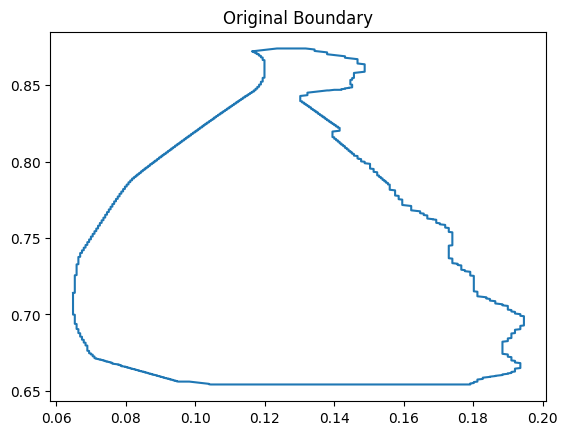

In [8]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(data["x"] / image_x_size, 1 - data["y"] / image_y_size)
plt.title("Original Boundary")

Text(0.5, 1.0, 'UV Boundary with Duplicates')

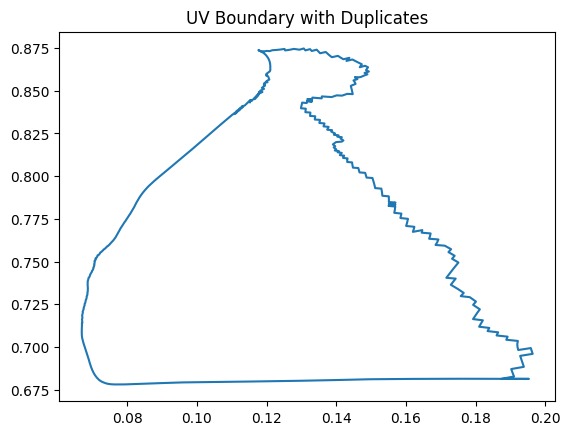

In [9]:
path = uv_array[boundary_uv_array]
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(path[:, 0], path[:, 1])
plt.title("UV Boundary with Duplicates")

Text(0.5, 1.0, 'UV Boundary without Duplicates')

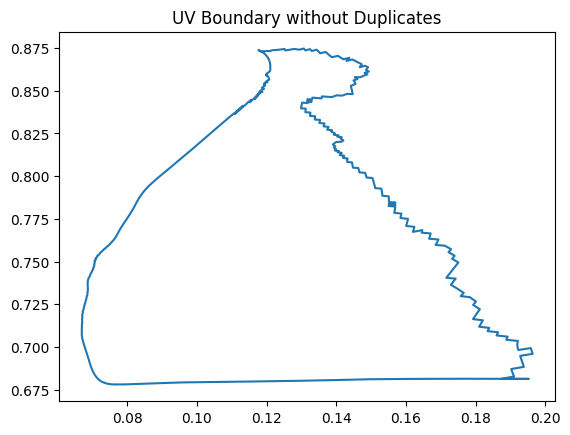

In [10]:
path = uv_array[cleaned_boundary_uv_array]
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(path[:, 0], path[:, 1])
plt.title("UV Boundary without Duplicates")

## Find the UV Points Inside the UV Boundary

In [11]:
boundary = mpltPath.Path(path)
inside_boundary = boundary.contains_points(uv_array)

### Visualize the Points that were Found

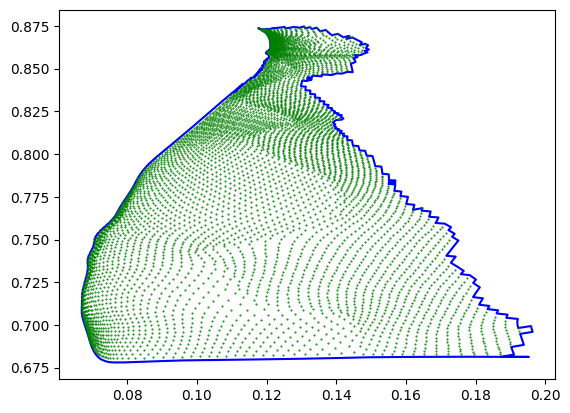

In [12]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(path[:, 0], path[:, 1], 'b-')
ax.plot(uv_array[inside_boundary, 0], uv_array[inside_boundary, 1], 'g.',
markersize=1)

### Check the Location on the Full UV Map

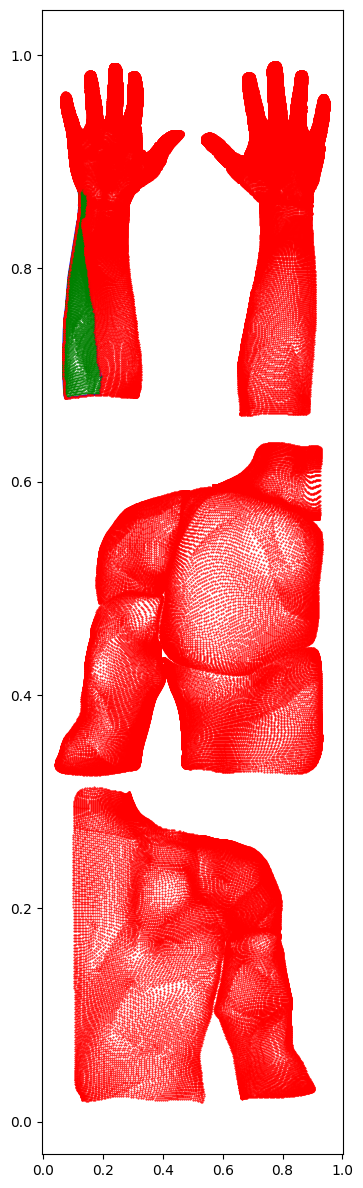

In [13]:
fig = plt.figure(figsize=(image_x_size/500, image_y_size/500))
ax = fig.add_subplot()
ax.plot(path[:, 0], path[:, 1], 'b-', markersize=2)
ax.plot(uv_array[inside_boundary, 0], uv_array[inside_boundary, 1], 'g.', markersize=1)
ax.plot(uv_array[np.invert(inside_boundary), 0],
        uv_array[np.invert(inside_boundary), 1], 'r.', markersize=1)

## Combine UV Indicies into an Array

In [14]:
inside_boundary_ids = [i for i, x in enumerate(inside_boundary) if x]
combined_uv_array = cleaned_boundary_uv_array.copy()
combined_uv_array.extend(inside_boundary_ids)

combined_uv_array_unique = []
[combined_uv_array_unique.append(x) for x in combined_uv_array if x not in combined_uv_array_unique]

combined_uv_array = np.array(combined_uv_array_unique)
location_uvs = np.array(uv_array[combined_uv_array])

## Translate the UVs to the 3D Mesh

### Find the Indicies of the Verticies from the UV Indicies

### Sort the UV Indicies

In [15]:
indicies_of_sorted_indicies = np.argsort(combined_uv_array)
sorted_indicies = combined_uv_array[indicies_of_sorted_indicies]

In [16]:
face_data_reduced = face_data[["vertex", "uv"]].drop_duplicates()
face_data_reduced = face_data_reduced.sort_values(by=['uv'])

### Find all Verticies at Once and Reorganize the Array Based on the Sort

In [17]:
sorted_vertex_ids = face_data_reduced[face_data_reduced['uv'].isin(combined_uv_array)]["vertex"].to_numpy()

vertex_ids = np.empty((len(combined_uv_array))).astype(int)

for index, value in enumerate(indicies_of_sorted_indicies):
    vertex_ids[value] = sorted_vertex_ids[index]

### Get the Vertex Positions using the Indicies

In [18]:
location_surface = np.array(mesh_verticies[vertex_ids])

### Check that the Shape of the Array is Correct (6597x3)

In [19]:
print(f"The shape of the array is {location_surface.shape}")

The shape of the array is (6597, 3)


### Show the Verticies in 3D

In [20]:
cloud = pv.PolyData(location_surface)
cloud.plot(color="black")

Widget(value="<iframe src='http://localhost:4078/index.html?ui=P_0x18fac59cfd0_0&reconnect=auto' style='width:…

### Triangulate the 3D Mesh

In [21]:
volume = cloud.delaunay_2d(alpha=0.05)
shell = volume.extract_geometry()
shell.plot(cmap=plt.cm.Spectral)

Widget(value="<iframe src='http://localhost:4078/index.html?ui=P_0x18fb0d9be80_1&reconnect=auto' style='width:…

## Show the Points on the Triangulated Mesh

In [22]:
p = pv.Plotter()
p.add_mesh(shell, show_edges=True, cmap=plt.cm.Spectral)
p.add_points(shell.points, color='red')
p.show()

Widget(value="<iframe src='http://localhost:4078/index.html?ui=P_0x18fb0e4c580_2&reconnect=auto' style='width:…

## Find the Surface Area of the 3D Location Drawing

In [23]:
print(f"The area of the drawn location is {shell.area} scene units")

The area of the drawn location is 0.8147511638722452 scene units
